In [112]:
import geopandas as gpd                 # spatial data
import pandas as pd                     # tabular data
import numpy as np                      # numerical ops
import matplotlib.pyplot as plt         # plots
from shapely import wkt                 # import used to convert strings into shapely Polygons

from libpysal.weights import Queen      # spatial weights
from esda.moran import Moran            # Moran’s I statistic
from esda.moran import Moran_Local      # Separate import to do Local Moran
from splot.esda import moran_scatterplot # plot Moran scatterplot

In [114]:
%matplotlib inline

# Data wrangling
# Had to deal accordingly with strings. First, convert to polygons. Then, convert from ' ' to nans to then drop them. 

# Load Week 2 output GeoJSON
gdf = gpd.read_file("elasticity_simulation.csv")
# Convert string geometries to shapely Polygons
gdf["geometry"] = gdf["geometry"].apply(wkt.loads)
# Re-assign as a GeoDataFrame with valid geometry
gdf = gpd.GeoDataFrame(gdf, geometry="geometry")

print("Rows loaded:", len(gdf))

# Convert empty strings to actual NaNs 
gdf["elasticity_estimate"].replace('', np.nan, inplace=True)
# Drop rows with missing elasticity
gdf = gdf.dropna(subset=["elasticity_estimate"])
print("Rows after dropping NaNs:", len(gdf))

Rows loaded: 113
Rows after dropping NaNs: 15


/var/folders/w3/f3zhp9t17_7cxs5hc0t1bznw0000gn/T/ipykernel_46889/463365524.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  gdf["elasticity_estimate"].replace('', np.nan, inplace=True)


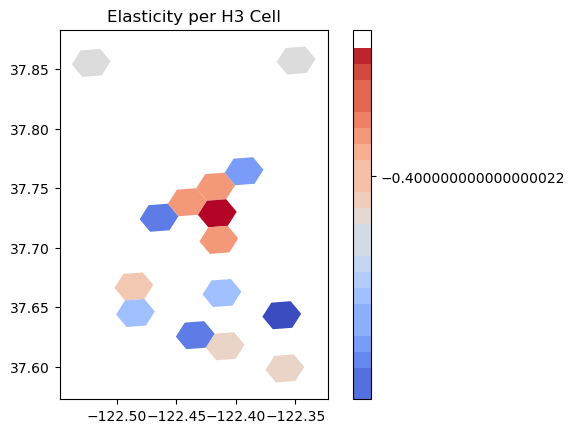

In [116]:
# Plot elasticity
# Convert strings to floats first
gdf["elasticity_estimate"] = pd.to_numeric(gdf["elasticity_estimate"], errors="coerce")
gdf.plot(column="elasticity_estimate", cmap="coolwarm", legend=True)
plt.title("Elasticity per H3 Cell")
plt.show()

# Red indicates strongest sensitivity to price change. Trips are most responsive to price changes.  
# Blue means lower elasticity. Trips happen regardless of price change. 

In [118]:
# Create spatial weights matrix (Queen contiguity). Queen contiguity means they are sharing a border or corner.
w = Queen.from_dataframe(gdf)

# Row-standardize weights. Each row sums to 1. 
w.transform = "R"

# Calculate Moran's I
y = gdf["elasticity_estimate"] # Measures whether similar values of elasticity_estimate are clustered together.
moran = Moran(y, w)

print(f"Moran’s I: {moran.I:.3f}, p-value: {moran.p_sim:.3f}")

# Calculate local moran. Later used to plot moran scatterplot and find 'sig.' 
local_moran = Moran_Local(y, w)
gdf["local_moran_I"] = local_moran.Is

# nearby cells have somewhat similar elasticity values (slight positive spatial correlation)
# p value is not statistically significant. we want p value < 0.05. 
# no strong evidence that spatial clustering of elasticity exists, it could be due to randomness.

('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 3, ' is an island (no neighbors)')
('WARNING: ', 4, ' is an island (no neighbors)')
('WARNING: ', 5, ' is an island (no neighbors)')
('WARNING: ', 6, ' is an island (no neighbors)')
Moran’s I: 0.128, p-value: 0.317


/var/folders/w3/f3zhp9t17_7cxs5hc0t1bznw0000gn/T/ipykernel_46889/4057634182.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(gdf)
/opt/anaconda3/lib/python3.12/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
 There are 5 islands with ids: 0, 3, 4, 5, 6.
  W.__init__(self, neighbors, ids=ids, **kw)
/opt/anaconda3/lib/python3.12/site-packages/esda/moran.py:1351: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim


<Figure size 600x600 with 0 Axes>

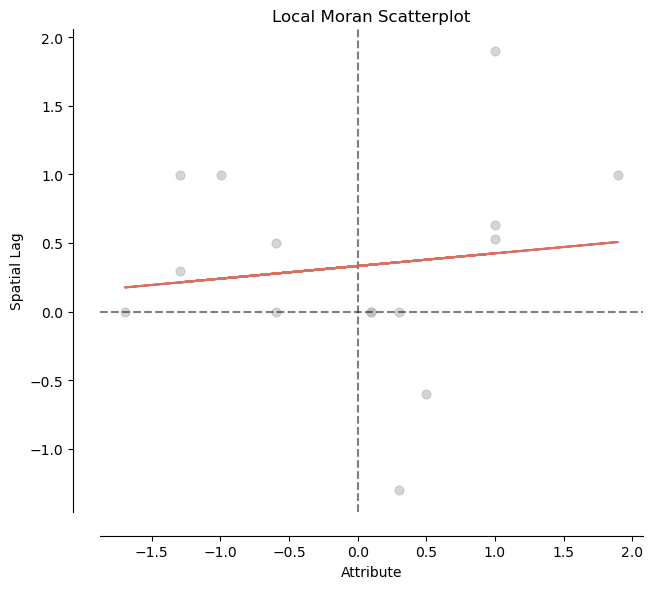

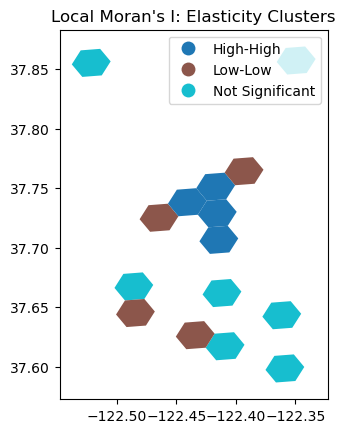

✅ Saved: h3_elasticity_clusters.geojson


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


In [122]:
# Plot Moran scatterplot
plt.figure(figsize=(6, 6))
moran_scatterplot(local_moran, zstandard=True)
plt.title("Local Moran Scatterplot")
plt.show()
# Red line shows spatial autocorrelation. Most points around the origin show weak or some spatial autocorrelation. 

# Add cluster classification (hot/cold spots)
gdf["moran_cluster"] = ["Not Significant"] * len(gdf)
sig = local_moran.q
gdf.loc[(sig==1), "moran_cluster"] = "High-High" # hot spot 
gdf.loc[(sig==2), "moran_cluster"] = "Low-Low" # cold spot 

# Plot clusters
gdf.plot(column="moran_cluster", legend=True)
plt.title("Local Moran's I: Elasticity Clusters")
plt.show()

# Save clustered output
gdf.to_file("h3_elasticity_clusters.geojson", driver="GeoJSON")
print("✅ Saved: h3_elasticity_clusters.geojson")


# High-High: people are very sensitive to price changes, and surrounding cells also show that high elasticity. 
# Low-low: demand has low elasticity (people aren't as sensitive to price change), and surrounding neighbors also have this 
# same price sensitivity